In [1]:
import re
import math
import codecs
import csv
import pandas as pd
import matplotlib.pyplot as plt
import typing
from collections import Counter
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

In [3]:
# Словарь аббривиатур и сокращений из CSV в словарь
def reductDictFromCSV(path: str) -> list:
    with codecs.open(path, 'r', encoding="utf_8_sig") as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        reductionsDict = {}
        for row in reader:
            reductionsDict[row[0]] = row[1].lower()
    return reductionsDict

In [4]:
# Список стоп слов из CSV в список
def getStopWordsListFromCSV(path: str) -> list:
    with codecs.open(path, 'r', encoding="utf_8_sig") as csvfile:
        reader = csv.reader(csvfile)
        stopWords = []
        for row in reader:
            stopWords.append(row[0].strip().lower())
    return stopWords

In [5]:
# Лемматизатор из CSV в словарь
def getLemmizatorDictFromCSV(path: str) -> dict:
    with codecs.open(path, 'r', encoding="utf_8_sig") as csvfile:
        reader = csv.reader(csvfile, delimiter='@')
        lemmizatorDict = {}
        for row in reader:
            lemmizatorDict[row[0].strip()] = row[1].strip()
    return lemmizatorDict

In [6]:
global REDUCTIONDICT, STOPWORDSLIST, LEMMIZATORDICT, NEWLEMMSLIST
# Словарь сокращений и аббривиатур
REDUCTIONDICT = reductDictFromCSV('reductions.csv')

In [7]:
# Список стоп слов
STOPWORDSLIST = getStopWordsListFromCSV('stopword.csv')

In [7]:
# Словарь Леммизатор
LEMMIZATORDICT = getLemmizatorDictFromCSV('D:\lemmatizator.csv')

In [8]:
# Список новых лемм
NEWLEMMSLIST = []

In [9]:
# Список всех слов из файла, формата Docx (Не изспользую)
def getListOfWordsFromDoc(filename: str) -> list:
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    text = '\n'.join(fullText)
    words = re.findall(r"\b[\w\-,\.]+\b", text)
    words.sort()
    return words

In [10]:
# Список всех слов из файла, формата TXT
def getListOfWordsFromTxt(filename: str) -> list:
    with codecs.open(filename, 'r', encoding="utf_8_sig") as file:
        txt = file.read()
    txt = clearReductFromTXT(txt) # Разворачиваем сокращения
    txt = re.sub(r'[Ёё]', 'е', txt)
    words = re.findall(r"[а-яА-ЯёЁ]{2,}", txt) # Вытаскиваю только слова из текста + токенизируем текст
    words = list(map(lambda x: x.strip().lower(), words)) # Приводим все слова к нижнему регистру
    words = getWordsListWithoutStopWords(words) # Чистим список слов от стоп слов
    words = lemmatizatorFromListOfWords(words) # Лемматизируем наш список слов
    return words # Возвращяем чистый список всех слов

In [11]:
# Обработка словаря на стоп слова
def getWordsListWithoutStopWords(words: list) -> list:
    for word in words: # Прохожусь циклом по всем словам
        if word in STOPWORDSLIST: # Если слово есть в списке Стоп Слов, то:
            wordQuantity = words.count(word)
            for _ in range(wordQuantity):
                words.remove(word) # Удаляем его
    return words

In [12]:
# Расшифровывает аббривиатуры и сокращения в тексте
def getTXTListWithoutStopWords(txt: str) -> str:
    for word in STOPWORDSLIST:
        txt = re.sub('\\\b' + word + '\\\b', '', txt)
    return txt

In [2]:
# Словарь частоты слов
def getFreqFromText(words: list) -> Counter:
    countedWords = Counter(words)
    return countedWords

In [15]:
# запись словаря в CSV
def dictToCSV(freqDict: dict, path: str) -> None:
    with codecs.open(path, "w", encoding="utf_8_sig") as csvfile:
        writer = csv.writer(csvfile, delimiter='^')
        for key in freqDict:              
            writer.writerow([key, freqDict[key]])

In [65]:
# Метод подсчитывает TF-IDF для списка документов (Не изспользую)
def compute_tfidf(corpus: list) -> list:
    def compute_tf(text: str) -> Counter:
        tf_text = getFreqFromText(text)
        
        if len(tf_text.keys()) > 3000:
            keysWithIncorrectValues = []
            for key in tf_text.keys():
                if tf_text[key] < 15:
                    keysWithIncorrectValues.append(key)
            for key in keysWithIncorrectValues:
                tf_text.pop(key)
                
        for i in tf_text:
            tf_text[i] = tf_text[i]/float(len(text))
        return tf_text

    def compute_idf(word: str, corpus: list) -> float:
        return math.log10(len(corpus)/sum([1.0 for i in corpus if word in i]))

    documents_list = []
    for text in corpus:
        tf_idf_dictionary = {}
        computed_tf = compute_tf(text)
        for word in computed_tf:
            tf_idf_dictionary[word] = computed_tf[word] * compute_idf(word, corpus)
        documents_list.append(tf_idf_dictionary)
    return documents_list

In [17]:
# Расшифровывает аббривиатуры и сокращения в списке (Не изспользую)
def clearReductFromWordList(wordsList: list) -> list:
    for word in wordsList:
        if word in REDUCTIONDICT.keys():
            wordsList[wordsList.index(word)] = REDUCTIONDICT[word]
    return wordsList

In [18]:
# Расшифровывает аббривиатуры и сокращения в тексте
def clearReductFromTXT(txt: str) -> str:
    for key in REDUCTIONDICT.keys():
        repl = REDUCTIONDICT[key]
        txt = re.sub('\\b' + key + '\\b', repl, txt)
    return txt

In [19]:
# Лемматизация списка слов
def lemmatizatorFromListOfWords(wordsList: list) -> list:
    for word in wordsList:
        if LEMMIZATORDICT.get(word) != None:
            wordsList[wordsList.index(word)] = LEMMIZATORDICT[word]
        else:
            if word not in NEWLEMMSLIST:
                NEWLEMMSLIST.append(word)
    return wordsList

In [20]:
# Создание общего словаря
def getGeneralList(freq: int, fileName: str) -> list:
    generalList = []
    for i in range(1, freq + 1):
        generalList += getListOfWordsFromTxt(f'Docs/{i}/{fileName}_{i}.txt')
        print(f'Файл №{i} обработан')
    return generalList

In [50]:
# Список списков слов из текста
def getListOfWordsLists(freq: int, fileName: str) -> list:
    listOfLists = []
    for i in range(1, freq + 1):
        listOfLists.append(getListOfWordsFromTxt(f'Docs/{i}/{fileName}_{i}.txt'))
    return listOfLists

In [22]:
# Создание TF-IDF и заголовков
def createTfidfAndHeader(corpus: list) -> list, list:
    computedTfidf = compute_tfidf(corpus)
    listOfKeys = [i.keys() for i in computedTfidf]
    
    header = []
    for key in listOfKeys:
        for word in key:
            if word not in header:
                header.append(word)
    
    return computedTfidf, header

In [40]:
# Запись матрицы TF-IDF в CSV
def tfidfToMatrix(path: str, freq: int, fileName: str) -> None:
    computedTfidf: list, header: list = createTfidfAndHeader(getListOfWordsLists(freq, fileName))
                
    with codecs.open(path, "w", encoding="utf_8_sig") as csvfile:
        writer = csv.writer(csvfile, delimiter='^')
        mainHeader = header.copy()
        mainHeader.insert(0, 'Номер колонок')
        writer.writerow(mainHeader)
        index = 1
        for dictTfidf in computedTfidf:
            listOfWords = []
            for headerWord in header:
                if headerWord in dictTfidf.keys():
                    listOfWords.append(dictTfidf[headerWord])
                else:
                    listOfWords.append(0.0)
            writer.writerow([index, *listOfWords])
            print(f'Файл №{index} обработан')
            index += 1

In [71]:
# Визуализация матрицы TF-IDF в виде дендограммы
def showDendogram(matrix: list, name: str) -> None:
    varieties = range(1, matrix.shape[0] + 1)
    samples = matrix.values
    mergings = linkage(samples, method='complete')
    dendrogram(mergings,
               labels=varieties,
               leaf_rotation=90,
               leaf_font_size=20,
               )
    plt.title(f'Файлы {name}')
    plt.show()

In [117]:
# Кластеризация TF-IDF матрицы с помощью метода ближайшего соседа
def showKmeans(matrix: list, name: str, n: int) -> None:
    model = KMeans(n_clusters=n)
    model.fit(matrix.values)
    all_predictions = model.predict(matrix.values).tolist()
    result = {}
    for index in range(len(all_predictions)):
        result[index + 1] = all_predictions[index]
#     print(all_predictions)
    print(result)

In [32]:
# dictToCSV(getFreqFromText(getListOfWordsFromTxt('Docs/1/com_1.txt')), 'test.csv')
# dictToCSV(getFreqFromText(getListOfWordsFromTxt('Docs/15/text_15.txt')), 'Docs/15/clear/dict_text_clear_15.csv')
# dictToCSV(getFreqFromText(getListOfWordsFromTxt('Docs/15/goals_15.txt')), 'Docs/15/clear/dict_goals_clear_15.csv')
# dictToCSV(getFreqFromText(getListOfWordsFromTxt('Docs/15/tasks_15.txt')), 'Docs/15/clear/dict_tasks_clear_15.csv')
# dictToCSV(getFreqFromText(getListOfWordsFromTxt('Docs/15/content_15.txt')), 'Docs/15/clear/dict_content_clear_15.csv')

In [36]:
# Создание словарей частот
startTime = time.time()
dictToCSV(getFreqFromText(getGeneralList(15)), 'general_dict.csv')
print(f'Прошло {time.time() - startTime} секунд')

Файл №1 обработан


KeyboardInterrupt: 

In [67]:
# Создание матриц
startTime = time.time()
for name in ['com', 'text', 'content', 'tasks', 'goals']:
    print(f'{name} файлы \n=============')
    tfidfToMatrix(f'matrices/{name}_matrix.csv', 15, name)
print(f'Прошло {time.time() - startTime} секунд')

com файлы 
Файл №1 обработан
Файл №2 обработан
Файл №3 обработан
Файл №4 обработан
Файл №5 обработан
Файл №6 обработан
Файл №7 обработан
Файл №8 обработан
Файл №9 обработан
Файл №10 обработан
Файл №11 обработан
Файл №12 обработан
Файл №13 обработан
Файл №14 обработан
Файл №15 обработан
text файлы 
Файл №1 обработан
Файл №2 обработан
Файл №3 обработан
Файл №4 обработан
Файл №5 обработан
Файл №6 обработан
Файл №7 обработан
Файл №8 обработан
Файл №9 обработан
Файл №10 обработан
Файл №11 обработан
Файл №12 обработан
Файл №13 обработан
Файл №14 обработан
Файл №15 обработан
content файлы 
Файл №1 обработан
Файл №2 обработан
Файл №3 обработан
Файл №4 обработан
Файл №5 обработан
Файл №6 обработан
Файл №7 обработан
Файл №8 обработан
Файл №9 обработан
Файл №10 обработан
Файл №11 обработан
Файл №12 обработан
Файл №13 обработан
Файл №14 обработан
Файл №15 обработан
tasks файлы 
Файл №1 обработан
Файл №2 обработан
Файл №3 обработан
Файл №4 обработан
Файл №5 обработан
Файл №6 обработан
Файл №7 обраб

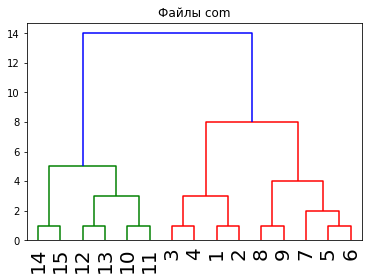

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


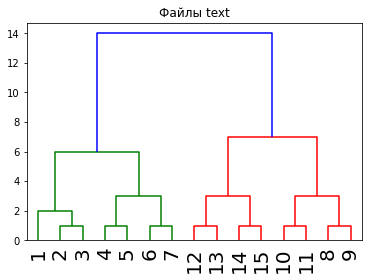

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


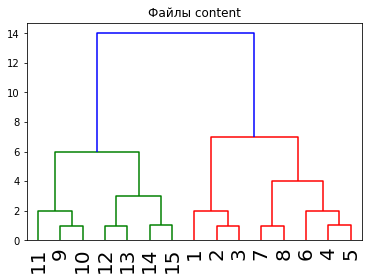

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1}


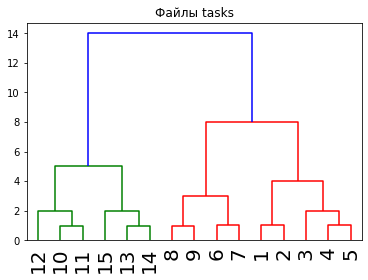

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0}


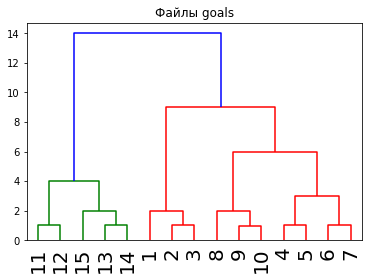

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1}


In [119]:
for name in ['com', 'text', 'content', 'tasks', 'goals']:
    martixdf = pd.read_csv(f'matrices/{name}_matrix.csv', delimiter='^', header=None, skiprows=1)
    martixdf.drop(0, axis=1)
    showDendogram(martixdf, name)
    showKmeans(martixdf, name, 2)